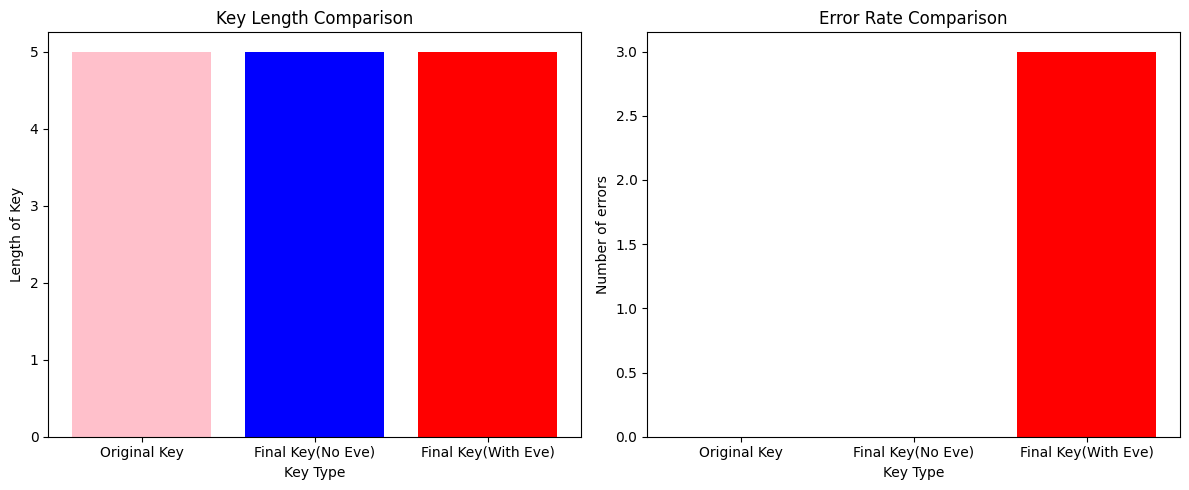

Original Key (Alice and Bob agreed on):  [0 0 0 0 1]
Final Secure Key(contains errors):  [1 1 0 0 0]
Corrected Key:  [0 0 0 0 1]


In [7]:
from qiskit import QuantumCircuit,transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

def generate_key_and_bases(n):
    key = np.random.randint(0,2,n)
    bases=np.random.randint(0,2,n)
    return key, bases

def prepare_qubits(key, bases):
    n = len(key)
    qc=QuantumCircuit(n,n)
    for i in range(n):
        if key[i]==1:
            qc.x(i)
        if bases[i]==1:
            qc.h(i)
    return qc

def measure_qubits(qc, bases):
    n = len(bases)
    for i in range(n):
        if bases[i]==1:
            qc.h(i)
    qc.measure(range(n), range(n))
    return qc

def eavesdrop(qc,n):
    eaves_bases = np.random.randint(0,2,n)
    eve_qc =  qc.copy()
    for i in range(n):
        if eaves_bases[i]==1:
            eve_qc.h(i)
    eve_qc.measure(range(n),range(n))
    simulator = Aer.get_backend('qasm_simulator')
    t_eve_qc = transpile(eve_qc,simulator)
    eve_result = simulator.run(t_eve_qc,shots=1).result()
    eve_results = np.array([int(bit) for bit in list(eve_result.get_counts().keys())[0]])[::-1]

    return eve_results, eaves_bases

def run_bb84(n, eaves=False):
    key, alice_bases = generate_key_and_bases(n)
    alice_qc=prepare_qubits(key,alice_bases)
    
    bob_bases = np.random.randint(0,2,n)
    bob_qc = measure_qubits(alice_qc.copy(),bob_bases)

    #simulation
    simulator = Aer.get_backend('qasm_simulator')
    t_qc = transpile(bob_qc,simulator)
    result = simulator.run(t_qc,shots=1).result()
    bob_results = np.array([int(bit) for bit in list(result.get_counts().keys())[0]])[::-1]

    matching_bases = alice_bases==bob_bases
    final_key_no_eave = bob_results[matching_bases]

    if eaves:
        eve_results, eaves_bases = eavesdrop(alice_qc,n)
        final_key_with_eave=[]
        for i in range(len(final_key_no_eave)):
            if np.random.rand()<0.5:
                final_key_with_eave.append(1-final_key_no_eave[i])
            else:
                final_key_with_eave.append(final_key_no_eave[i])
        final_key_with_eave = np.array(final_key_with_eave)
    else:
        final_key_with_eave = final_key_no_eave
    return final_key_no_eave, final_key_with_eave, key[matching_bases]

def error_check(alice_key, bob_key):
    block_size =1
    while block_size<= len(alice_key):
        for i in range(0, len(alice_key), block_size*2):
            block = alice_key[i:i+block_size]
            parity= np.sum(block)%2
            bob_parity = np.sum(bob_key[i:i+block_size])%2
            if parity!=bob_parity:
                for j in range(i, i+block_size):
                    if alice_key[j]!=bob_key[j]:
                        bob_key[j]=alice_key[j]
                        break
        block_size*=2
    return bob_key

def plot_results(original_key, final_key_no_eave, final_key_with_eave):
    labels = ["Original Key", "Final Key(No Eve)", "Final Key(With Eve)"]
    lengths = [len(original_key), len(final_key_no_eave), len(final_key_with_eave)]
    errors= [0,0,np.sum(final_key_no_eave!= final_key_with_eave)]
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.bar(labels, lengths, color=['pink','blue','red'])
    plt.xlabel("Key Type")
    plt.ylabel("Length of Key")
    plt.title("Key Length Comparison")

    plt.subplot(1,2,2)
    plt.bar(labels, errors, color=['pink','blue','red'])
    plt.xlabel("Key Type")
    plt.ylabel("Number of errors")
    plt.title("Error Rate Comparison")

    plt.tight_layout()
    plt.show()
def print_results(original_key, final_key_no_eave, final_key_with_eave, corrected_key_noEave, corrected_key_withEave,eaves):
    if eaves:
        print("Original Key (Alice and Bob agreed on): ", original_key)
        print("Final Secure Key(contains errors): ",final_key_with_eave)
        print("Corrected Key: ",corrected_key_withEave)
    else:
        print("Original Key (Alice and Bob agreed on): ", original_key)
        print("Final Secure Key(No Eave): ",final_key_no_eave)
        print("Corrected Key(No Eave): ",corrected_key_noEave)
if __name__ == "__main__":
    n = 10
    eaves = True
    final_key_no_eave, final_key_with_eave, original_key = run_bb84(n,eaves)
    corrected_key_noEave = error_check(original_key, final_key_no_eave.copy())
    corrected_key_withEave = error_check(original_key, final_key_with_eave.copy())

    plot_results(original_key, final_key_no_eave, final_key_with_eave)
    print_results(original_key, final_key_no_eave, final_key_with_eave, corrected_key_noEave, corrected_key_withEave, eaves)
